# LSTM Model With Pre-Trained GLoVe Embedding

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
data[1000:].head(10)

,id,keyword,location,text,target
1000,1452,body%20bagging,NaN,#OVOFest Drake straight body bagging Meek on t...,0
1001,1453,body%20bagging,NaN,I'm not a Drake fan but I enjoy seeing him bod...,0
1002,1454,body%20bagging,NaN,@amaramin3 Meek is definitely capable of body ...,0
1003,1455,body%20bagging,3?3?7?SLOPelousas??2?2?5?,Gates not body bagging nobody???????? niggas i...,0
1004,1456,body%20bagging,NaN,WWE 2k15 MyCareer EP18 Tyrone body bagging dud...,0
1005,1458,body%20bagging,316,'I did another one I did another one. You stil...,1
1006,1459,body%20bagging,Global,Drake Body Bagging Meek. He must of hit a sens...,0
1007,1460,body%20bagging,#WhereverI'mAt,Good diss bad beat and flow. Mark my words Mee...,0
1008,1463,body%20bagging,"Huber Heights, OH",@Drake is body bagging meek meanwhile he's on ...,0
1009,1464,body%20bagging,NaN,@MzGracieBaby for the record im jumpin out the...,0


In [2]:
data['keyword'] = data['keyword'].str.replace('%\d+', ' ', regex=True)
data['keyword'] = data['keyword'].str.lower()
data['keyword'] = data['keyword'].fillna('')

data['text'] = data['text'].str.replace('http\S+', 'http', regex=True)  # replace all URLs with "http"
data['text'] = data['text'].str.replace('&\S+', '', regex=True)  # remove all html junks
data['text'] = data['text'].str.replace('[0-9]','0', regex=True)  # replace all integer valeus with 0
data['text'] = data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
data['text'] = data['text'].str.lower()


data['location'] = data['location'].str.replace('http\S+', 'http', regex=True)
data['location'] = data['location'].str.replace('&\S+', '', regex=True)
data['location'] = data['location'].str.replace('[0-9]','0', regex=True)
data['location'] = data['location'].str.replace('[^a-zA-Z0 ]', '', regex=True)
data['location'] = data['location'].str.lower()
data['location'] = data['location'].fillna('')

data[1000:].head(10)

,id,keyword,location,text,target
1000,1452,body bagging,,ovofest drake straight body bagging meek on th...,0
1001,1453,body bagging,,im not a drake fan but i enjoy seeing him body...,0
1002,1454,body bagging,,amaramin0 meek is definitely capable of body b...,0
1003,1455,body bagging,000slopelousas000,gates not body bagging nobody niggas in br rea...,0
1004,1456,body bagging,,wwe 0k00 mycareer ep00 tyrone body bagging dud...,0
1005,1458,body bagging,000,i did another one i did another one you still ...,1
1006,1459,body bagging,global,drake body bagging meek he must of hit a sensi...,0
1007,1460,body bagging,whereverimat,good diss bad beat and flow mark my words meek...,0
1008,1463,body bagging,huber heights oh,drake is body bagging meek meanwhile hes on to...,0
1009,1464,body bagging,,mzgraciebaby for the record im jumpin out the ...,0


In [3]:
config = {
    'key_max_len': 3,
    'loc_max_len': 7,
    'text_max_len': 35,
}

In [4]:
import pickle

glove_dict = dict()  # dictionary containing pre-trained GLoVe, with 100 dimension vector representing a word

with open('glove.pickle', 'rb') as p:
    glove_dict = pickle.load(p)

In [5]:
def embAndPad(pd_series, max_length):
    ret = []
    for entry in pd_series:
        emb_sent = []
        words = entry.split()
        for word in words:
            try:  # if the word is in the GLoVe data
                emb_sent.append(glove_dict[word])
            except KeyError:
                pass
        while len(emb_sent) < max_length:  # paddings
            emb_sent.append(np.zeros(100, dtype='float32'))
        ret.append(np.asarray(emb_sent)[:max_length])
    return np.asarray(ret)

In [6]:
seq_input = embAndPad(data['text'], config['text_max_len'])
key_input = embAndPad(data['keyword'], config['key_max_len'])
loc_input = embAndPad(data['location'], config['loc_max_len'])
print(seq_input[0])  # you can see a single word is converted into a 100 dimension vector

[[-0.085462  0.11468   0.63305  ... -0.25772   0.57399   1.4787  ]
 [ 0.43133  -0.088912 -0.06145  ... -0.24217  -0.53863  -0.13046 ]
 [-0.51533   0.83186   0.22457  ... -1.2024    1.1304    0.3479  ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [7]:
output = data['target'].to_numpy()

print("seq_input Shape: ", seq_input.shape)
print("key_input Shape: ", key_input.shape)
print("loc_input Shape: ", loc_input.shape)
print("output Shape: ", output.shape)

seq_input Shape:  (7613, 35, 100)
key_input Shape:  (7613, 3, 100)
loc_input Shape:  (7613, 7, 100)
output Shape:  (7613,)


In [8]:
import tensorflow as tf

x_seq = tf.keras.layers.Input(shape=(config['text_max_len'], 100), name='seq_input')
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x_seq)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x1)

x_key = tf.keras.layers.Input(shape=(config['key_max_len'], 100), name='key_input')
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x_key)

x_loc = tf.keras.layers.Input(shape=(config['loc_max_len'], 100), name='loc_input')
x3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x_loc)
x3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x3)

x = tf.keras.layers.Concatenate()([x1, x2, x3])
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq, x_key, x_loc], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 35, 100)]    0                                            
__________________________________________________________________________________________________
loc_input (InputLayer)          [(None, 7, 100)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 35, 256)      234496      seq_input[0][0]                  
__________________________________________________________________________________________________
key_input (InputLayer)          [(None, 3, 100)]     0                                            
_______________________________________________________________________________________

In [9]:
history = model.fit(x={'seq_input':seq_input, 'key_input':key_input, 'loc_input':loc_input}, y=output, epochs=20, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 10s 51ms/step - loss: 0.5515 - accuracy: 0.7335 - val_loss: 0.4537 - val_accuracy: 0.7971
Epoch 2/20
191/191 [==============================] - 6s 34ms/step - loss: 0.4465 - accuracy: 0.8089 - val_loss: 0.4347 - val_accuracy: 0.8102
Epoch 3/20
191/191 [==============================] - 6s 33ms/step - loss: 0.4221 - accuracy: 0.8194 - val_loss: 0.4171 - val_accuracy: 0.8175
Epoch 4/20
191/191 [==============================] - 7s 34ms/step - loss: 0.4073 - accuracy: 0.8256 - val_loss: 0.4181 - val_accuracy: 0.8142
Epoch 5/20
191/191 [==============================] - 7s 36ms/step - loss: 0.3992 - accuracy: 0.8294 - val_loss: 0.4188 - val_accuracy: 0.8142
Epoch 6/20
191/191 [==============================] - 6s 34ms/step - loss: 0.3862 - accuracy: 0.8350 - val_loss: 0.4301 - val_accuracy: 0.8096
Epoch 7/20
191/191 [==============================] - 7s 34ms/step - loss: 0.3774 - accuracy: 0.8422 - val_loss: 0.4288 - val_accuracy: 0.811

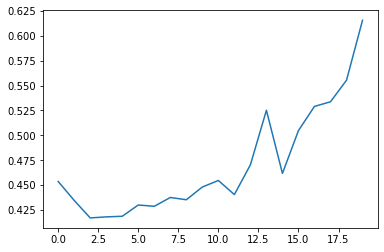

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])

In [11]:
# rebuild the same model to reset weights

x_seq = tf.keras.layers.Input(shape=(config['text_max_len'], 100), name='seq_input')
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x_seq)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x1)

x_key = tf.keras.layers.Input(shape=(config['key_max_len'], 100), name='key_input')
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x_key)

x_loc = tf.keras.layers.Input(shape=(config['loc_max_len'], 100), name='loc_input')
x3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x_loc)
x3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x3)

x = tf.keras.layers.Concatenate()([x1, x2, x3])
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq, x_key, x_loc], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 35, 100)]    0                                            
__________________________________________________________________________________________________
loc_input (InputLayer)          [(None, 7, 100)]     0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 35, 256)      234496      seq_input[0][0]                  
__________________________________________________________________________________________________
key_input (InputLayer)          [(None, 3, 100)]     0                                            
_______________________________________________________________________________________

In [12]:
history = model.fit(x={'seq_input':seq_input, 'key_input':key_input, 'loc_input':loc_input}, y=output, epochs=5)

Epoch 1/5
238/238 [==============================] - 7s 31ms/step - loss: 0.5317 - accuracy: 0.7487
Epoch 2/5
238/238 [==============================] - 8s 34ms/step - loss: 0.4341 - accuracy: 0.8063
Epoch 3/5
238/238 [==============================] - 8s 32ms/step - loss: 0.4166 - accuracy: 0.8187
Epoch 4/5
238/238 [==============================] - 7s 30ms/step - loss: 0.4012 - accuracy: 0.8261
Epoch 5/5
238/238 [==============================] - 7s 30ms/step - loss: 0.3936 - accuracy: 0.8304


In [16]:
# Apply Preprocssing to Test Data

test_data = pd.read_csv('test.csv')

test_data['location'] = test_data['location'].str.replace('http\S+', 'http', regex=True) 
test_data['location'] = test_data['location'].str.replace('&\S+', '', regex=True)  
test_data['location'] = test_data['location'].str.replace('[0-9]','0', regex=True)  
test_data['location'] = test_data['location'].str.replace('[^a-zA-Z0 ]', '', regex=True)
test_data['location'] = test_data['location'].str.lower()
test_data['location'] = test_data['location'].fillna('')

test_data['keyword'] = test_data['keyword'].str.replace('%\d+', ' ', regex=True)
test_data['keyword'] = test_data['keyword'].fillna('')

test_data['text'] = test_data['text'].str.replace('http\S+', 'http', regex=True)
test_data['text'] = test_data['text'].str.replace('&\S+', '', regex=True)
test_data['text'] = test_data['text'].str.replace('[0-9]','0', regex=True)
test_data['text'] = test_data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
test_data['text'] = test_data['text'].str.lower()

key_input_test = embAndPad(test_data['keyword'], config['key_max_len'])
loc_input_test = embAndPad(test_data['location'], config['loc_max_len'])
seq_input_test = embAndPad(test_data['text'], config['text_max_len'])

print("seq_input_test Shape: ", seq_input_test.shape)
print("key_input_test Shape: ", key_input_test.shape)
print("loc_input_test Shape: ", loc_input_test.shape)

seq_input_test Shape:  (3263, 35, 100)
key_input_test Shape:  (3263, 3, 100)
loc_input_test Shape:  (3263, 7, 100)


In [17]:
pred = model.predict(x={'seq_input':seq_input_test, 'key_input':key_input_test, 'loc_input':loc_input_test})
pred = np.asarray(np.rint(pred), dtype=int)
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [18]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = pred
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [44]:
submission.to_csv('submission2.csv', index=False)
# Accuracy Score : 0.81366